In [ ]:
import torch.nn as nn
import torchvision
import lightning as L
import pandas as pd

# DetoxAI
import detoxai
from detoxai.utils.datasets import get_detoxai_datasets, DetoxaiDataset
from detoxai.utils.transformations import SquarePad
from detoxai.utils.dataloader import DetoxaiDataLoader
from detoxai.core.model_wrappers import FairnessLightningWrapper
from detoxai.visualization import ScatterVisualizer, SSVisualizer
from detoxai import download_datasets, CorrectionResult

L.seed_everything(42, workers=True)

device = "cpu"
detoxai.__version__

Seed set to 42


'0.3.0'

 Let's start from fine-tuning a pretrained ResNet on a CelebA dataset

# Step 1: Download CelebA dataset 
We have a utility function for downloading celeba and fairface datasets and then another utility function to parse the dataset. Feel free to use them or download the dataset manually and parse it yourself. 


In [2]:
download_datasets(["celeba"])

CELEBA_DATASET_CONFIG = {
    "name": "celeba",
    "target": "Smiling",  # target attribute that should be predicted
    # Note that celeba has quite a lot of examples, so to make things easier,
    # we will use a smaller subset of the dataset
    "splits": {"train": 0.003, "test": 0.01, "unlearn": 0.003, "no": 0.984},
}

datasets: list[DetoxaiDataset] = get_detoxai_datasets(
    CELEBA_DATASET_CONFIG,
    transform=torchvision.transforms.Compose(
        [SquarePad(), torchvision.transforms.ToTensor()]
    ),
    device=device,
)

### Step 2: Setup the dataset and dataloaders 
Dataloader has to output tuples of (image, label, protected attribute)

In [ ]:
pa = "Wearing_Hat"  # protected attribute
pa_value = 1  # protected attribute value

collator_config = {
    "protected_attribute": pa,
    "protected_attribute_value": pa_value,
    "target_class": 1,
}

num_classes = datasets["train"].get_num_classes()
collate_fn = datasets["train"].get_collate_fn(pa, pa_value)

dataloader_train = DetoxaiDataLoader(
    datasets["train"], collate_fn=collate_fn, batch_size=128
)
dataloader_unlearn = DetoxaiDataLoader(
    datasets["unlearn"], collate_fn=collate_fn, batch_size=128
)
dataloader_test = DetoxaiDataLoader(
    datasets["test"], collate_fn=collate_fn, batch_size=128
)

### Step 3: Define the model  

DetoxAI supports binary classification and binary protected attributes

In [4]:
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
model.fc = nn.Linear(model.fc.in_features, 2)  # Make it binary classification
model = model.to(device)

Step 4: Fine-tune the model on the CelebA dataset  

We use our FairnessLightningWrapper, but you can also use the standard PyTorch Lightning module or any other training framework. The only thing you have to keep in mind is adapting your training procedure to handle the protected attribute. If you don't know how to do that, go ahead and check out our FairnessLightningWrapper. It should be fairly simple to understand.

In [5]:
trainer = L.Trainer(
    logger=False,
    max_epochs=1,
    devices=[int(str(device).split(":")[1])] if str(device) != "cpu" else 1,
    accelerator="gpu" if "cuda" in device else "cpu",
)
trainer.fit(FairnessLightningWrapper(model), dataloader_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ignacy/detoxai/research_code/checkpoints exists and is not empty.

  | Name      | Type             | Params | Mode 
--------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:758: `training_step` must be implemented to be used with the Lightning Trainer
`Trainer.fit` stopped: `max_epochs=1` reached.


### Step 5: After fine-tuning, visualize saliency maps to see the "before"

The first type of visualization are aggregated images and saliency maps side-by-side. They show the average image and saliency map for each class and protected attribute combination. 

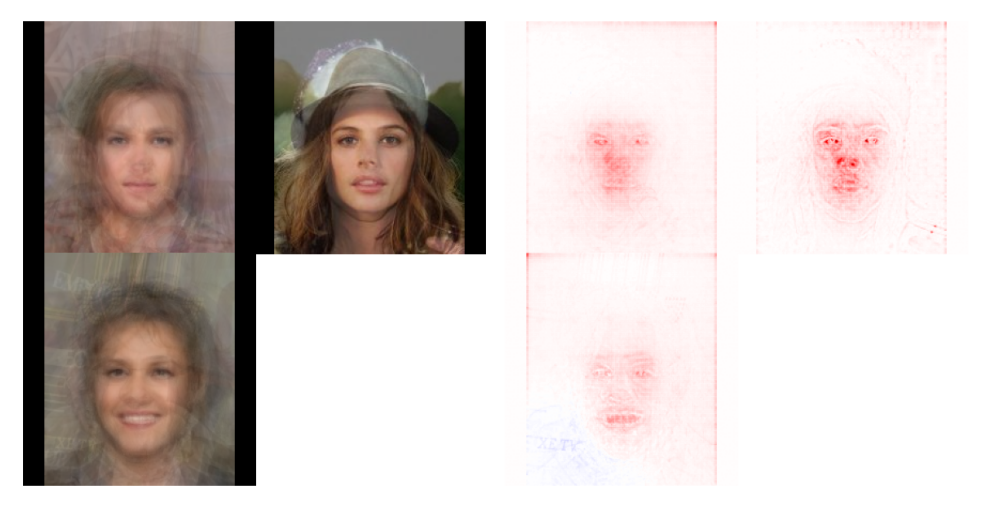

In [ ]:
visualizer = SSVisualizer(dataloader_train, model)
visualizer.visualize_agg(0)

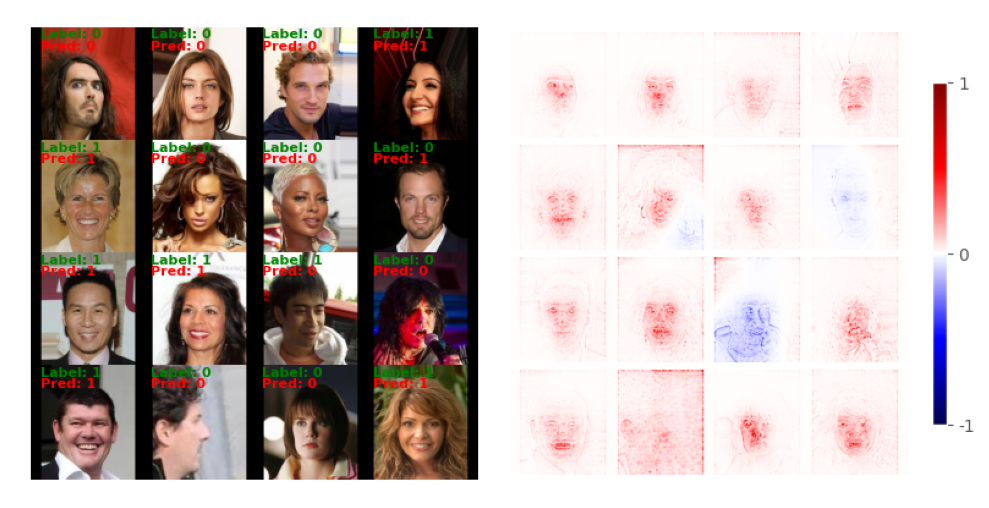

In [7]:
visualizer.visualize_batch(batch_num=0, max_images=16)

### Step 6: Debiasing with DetoxAI

First, check the available debiasing methods

In [20]:
detoxai.get_supported_methods()

AttributeError: module 'detoxai' has no attribute 'get_supported_methods'

Then start the debiasing process through `.debias()`. This will take a while, because many of the methods are computationally expensive as they fine-tune the model in their own way.

In [ ]:
# this will run all the debiasing methods,
# you can pass which ones you want to run by passing methods=["RRCLARC", "SAVANIAFT", ...]
results: dict[str, CorrectionResult] = detoxai.debias(
    model,
    dataloader_unlearn,
    test_dataloader=dataloader_test,
    # methods=["RRCLARC", "LEACE", "ZHANGM", "SAVANIAFT", "NT"],
    methods=["NT"],
)

/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'performance_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['performance_metrics'])`.
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/uti

Extracting Activations: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:44: Attribute 'model' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['model'])`.
/home/ignacy/detoxai/research_code/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=1` reached.


Let's see what we have in the end.

In [13]:
results

{'RRCLARC': Results for: RRCLARC}

In [16]:
rrclarc_model = results["RRCLARC"].get_model()

Visualize the saliency maps again to see the "after" for RRCLARC.

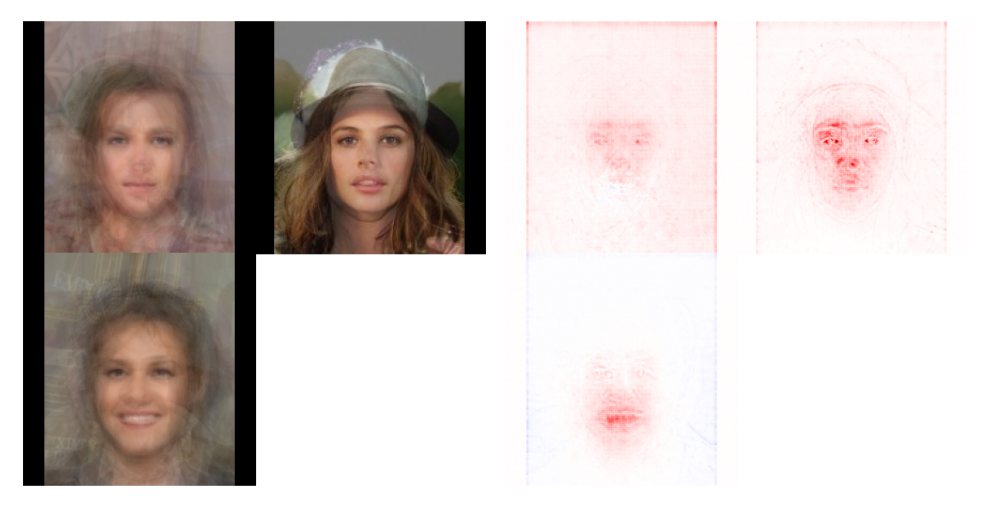

In [ ]:
visualizer_rrclarc = SSVisualizer(dataloader_train, rrclarc_model)
visualizer_rrclarc.visualize_agg(0)

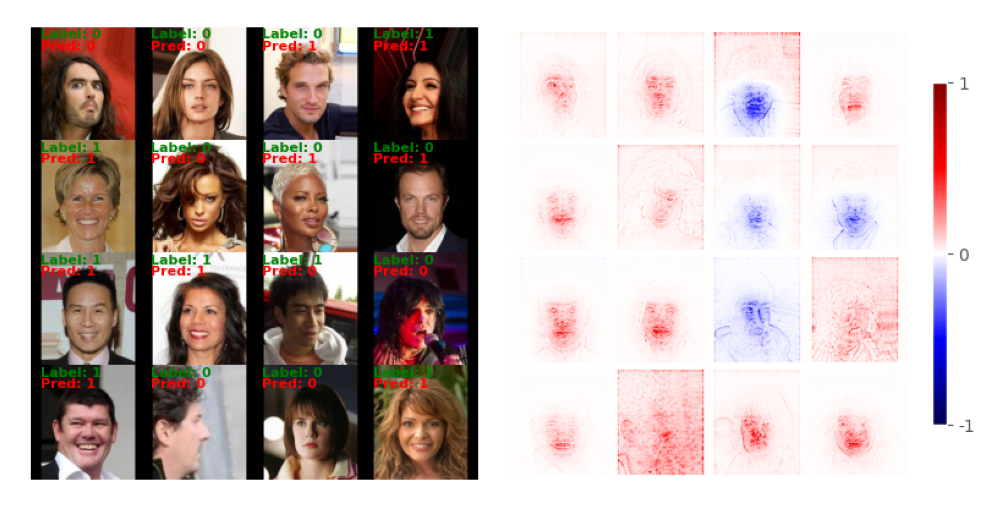

In [15]:
visualizer_rrclarc.visualize_batch(batch_num=0, max_images=16)

We can also see all the methods and their final fairness vs performance trade-off on a scatter plot

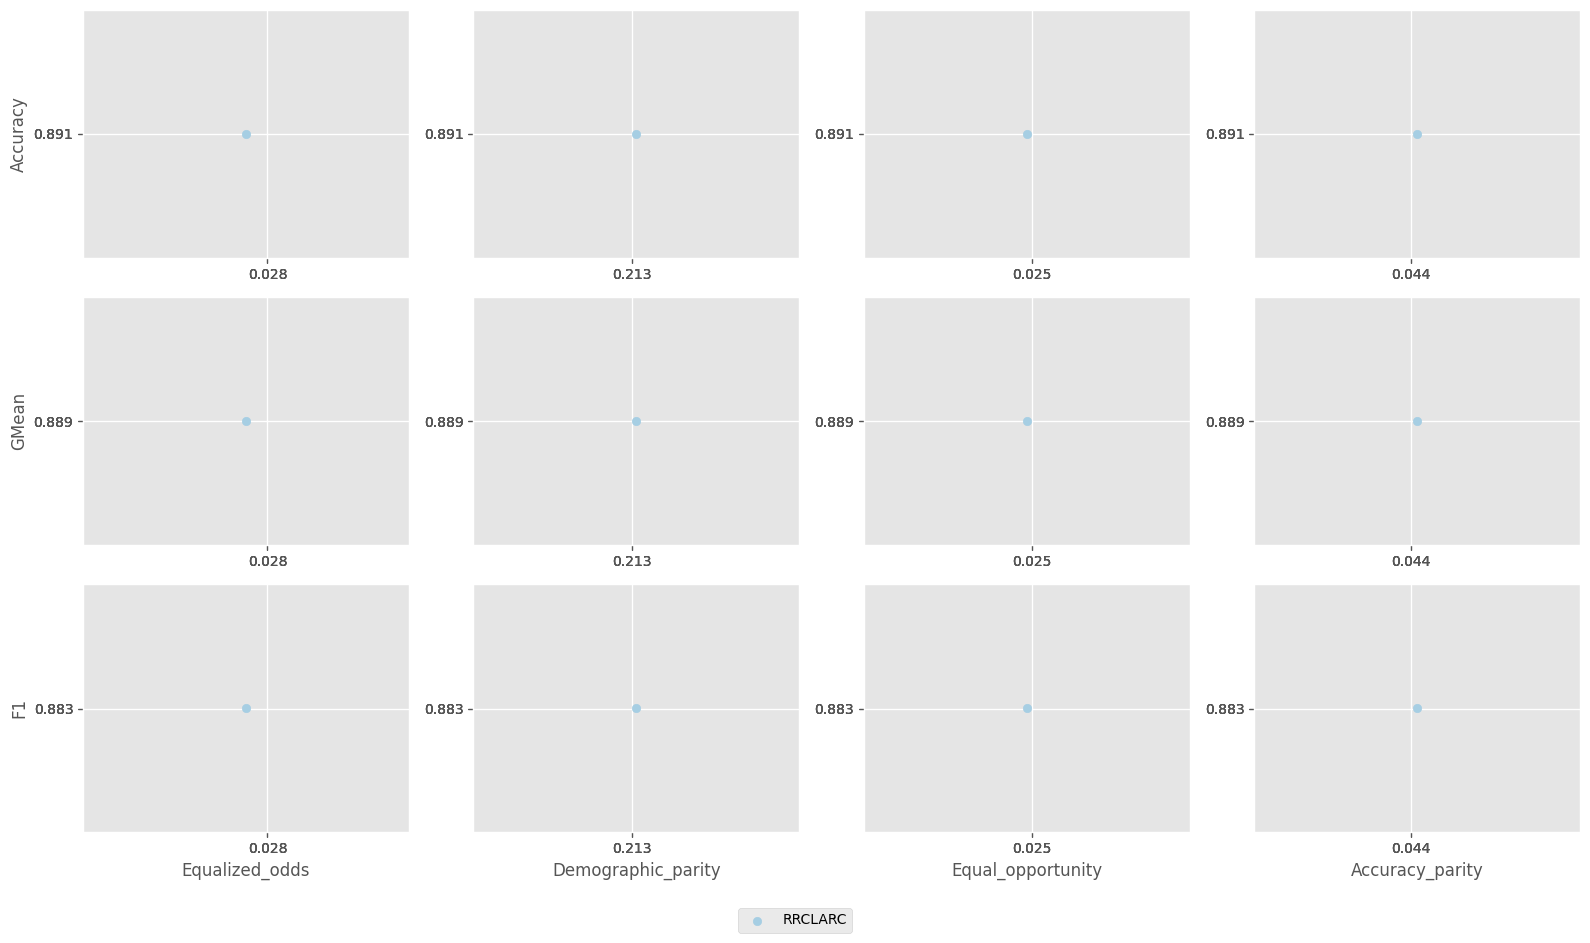

In [19]:
scatter_vis = ScatterVisualizer()

metrics = []
for result in results.values():
    _metrics = result.get_all_metrics()["all"]
    _method_name = result.get_method()
    _metrics["method"] = _method_name
    metrics.append(_metrics)
df = pd.DataFrame(metrics)

scatter_vis.create_plot(df)